## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

**Total points: 100**

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [19]:
tmp = np.load('../slides/eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [20]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [21]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [22]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.7064, Test Loss: 0.6442
Epoch 2/200, Loss: 0.5949, Test Loss: 0.6308
Epoch 3/200, Loss: 0.5461, Test Loss: 0.6690
Epoch 4/200, Loss: 0.5020, Test Loss: 0.5907
Epoch 5/200, Loss: 0.4774, Test Loss: 0.5583
Epoch 6/200, Loss: 0.4632, Test Loss: 0.5886
Epoch 7/200, Loss: 0.4374, Test Loss: 0.4962
Epoch 8/200, Loss: 0.4105, Test Loss: 0.4927
Epoch 9/200, Loss: 0.3872, Test Loss: 0.5034
Epoch 10/200, Loss: 0.3808, Test Loss: 0.5077
Epoch 11/200, Loss: 0.3694, Test Loss: 0.4903
Epoch 12/200, Loss: 0.3657, Test Loss: 0.4770
Epoch 13/200, Loss: 0.3543, Test Loss: 0.4942
Epoch 14/200, Loss: 0.3460, Test Loss: 0.4669
Epoch 15/200, Loss: 0.3390, Test Loss: 0.4774
Epoch 16/200, Loss: 0.3334, Test Loss: 0.4798
Epoch 17/200, Loss: 0.3322, Test Loss: 0.4594
Epoch 18/200, Loss: 0.3318, Test Loss: 0.4757
Epoch 19/200, Loss: 0.3295, Test Loss: 0.4851
Epoch 20/200, Loss: 0.3301, Test Loss: 0.4878
Epoch 21/200, Loss: 0.3281, Test Loss: 0.4880
Epoch 22/200, Loss: 0.3277, Test Loss: 0.48

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

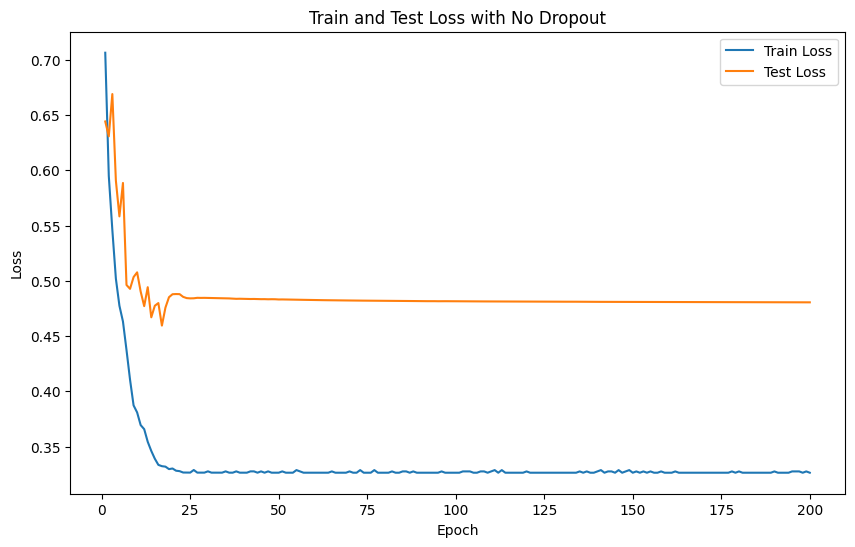

In [24]:
## INSERT CODE HERE
def plot_losses(train_losses, test_losses, dropout=False):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Test Loss with {f"Dropout={dropout}" if dropout else "No Dropout"}')
    plt.legend()
    plt.show()
plot_losses(train_losses, test_losses, dropout=False)

## Task 2: Compute the minimum train and test loss achieved during training and report them

In [25]:
## INSERT CODE HERE
def report_min_losses(train_losses, test_losses):
    min_train_loss = min(train_losses)
    min_train_epoch = train_losses.index(min_train_loss) + 1
    min_test_loss = min(test_losses)
    min_test_epoch = test_losses.index(min_test_loss) + 1
    print(f'Minimum train loss {min_train_loss} at epoch {min_train_epoch}')
    print(f'Minimum test loss {min_test_loss} at epoch {min_test_epoch}')

report_min_losses(train_losses, test_losses)

Minimum train loss 0.32628411302963894 at epoch 200
Minimum test loss 0.45944057901700336 at epoch 17


## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [26]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # INSERT CODE 
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        x = self.dropout(x)
        # INSERT CODE BELOW
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [27]:
## INSERT CODE BELOW

model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.2)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6884, Test Loss: 0.6793
Epoch 2/200, Loss: 0.5785, Test Loss: 0.6319
Epoch 3/200, Loss: 0.5334, Test Loss: 0.6083
Epoch 4/200, Loss: 0.4868, Test Loss: 0.5769
Epoch 5/200, Loss: 0.4501, Test Loss: 0.5690
Epoch 6/200, Loss: 0.4110, Test Loss: 0.5649
Epoch 7/200, Loss: 0.3986, Test Loss: 0.5624
Epoch 8/200, Loss: 0.3880, Test Loss: 0.5622
Epoch 9/200, Loss: 0.3756, Test Loss: 0.5452
Epoch 10/200, Loss: 0.3649, Test Loss: 0.5557
Epoch 11/200, Loss: 0.3553, Test Loss: 0.5437
Epoch 12/200, Loss: 0.3564, Test Loss: 0.5692
Epoch 13/200, Loss: 0.3546, Test Loss: 0.6143
Epoch 14/200, Loss: 0.3528, Test Loss: 0.5516
Epoch 15/200, Loss: 0.3427, Test Loss: 0.5486
Epoch 16/200, Loss: 0.3371, Test Loss: 0.5636
Epoch 17/200, Loss: 0.3330, Test Loss: 0.5049
Epoch 18/200, Loss: 0.3391, Test Loss: 0.5205
Epoch 19/200, Loss: 0.3346, Test Loss: 0.5733
Epoch 20/200, Loss: 0.3289, Test Loss: 0.5861
Epoch 21/200, Loss: 0.3267, Test Loss: 0.5691
Epoch 22/200, Loss: 0.3230, Test Loss: 0.57

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

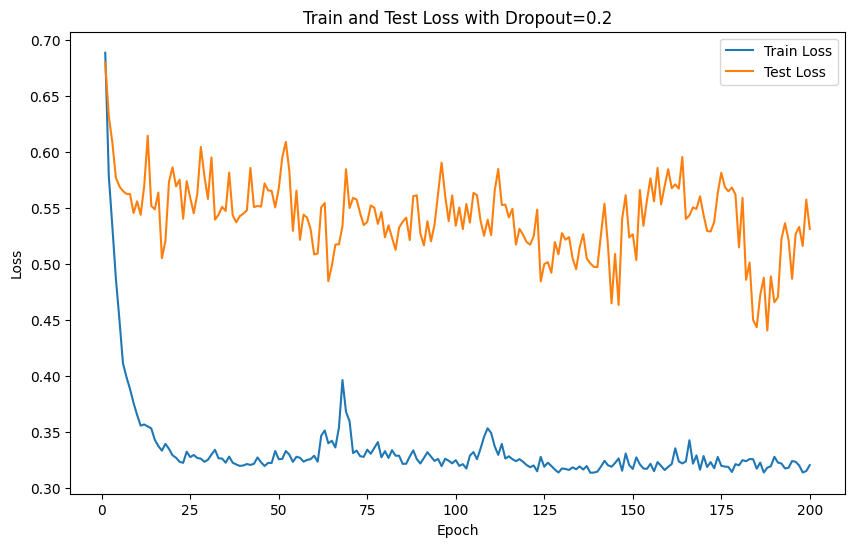

In [28]:
# INSERT CODE HERE
plot_losses(train_losses, test_losses, dropout=0.2)

## Task 6: Compute the minimum train and test loss achieved during training and report them

In [29]:
# INSERT CODE HERE
report_min_losses(train_losses, test_losses)

Minimum train loss 0.3132847671707471 at epoch 138
Minimum test loss 0.44026505947113037 at epoch 188


## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [30]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.5)
## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7257, Test Loss: 0.6745
Epoch 2/200, Loss: 0.6739, Test Loss: 0.6333
Epoch 3/200, Loss: 0.5974, Test Loss: 0.6209
Epoch 4/200, Loss: 0.5621, Test Loss: 0.6194
Epoch 5/200, Loss: 0.5669, Test Loss: 0.5900
Epoch 6/200, Loss: 0.5346, Test Loss: 0.5900
Epoch 7/200, Loss: 0.5318, Test Loss: 0.5829
Epoch 8/200, Loss: 0.4949, Test Loss: 0.5963
Epoch 9/200, Loss: 0.4845, Test Loss: 0.5683
Epoch 10/200, Loss: 0.4773, Test Loss: 0.5367
Epoch 11/200, Loss: 0.4552, Test Loss: 0.5452
Epoch 12/200, Loss: 0.4333, Test Loss: 0.5244
Epoch 13/200, Loss: 0.4360, Test Loss: 0.5080
Epoch 14/200, Loss: 0.4110, Test Loss: 0.5271
Epoch 15/200, Loss: 0.4288, Test Loss: 0.5460
Epoch 16/200, Loss: 0.4122, Test Loss: 0.4946
Epoch 17/200, Loss: 0.3909, Test Loss: 0.4845
Epoch 18/200, Loss: 0.3869, Test Loss: 0.5533
Epoch 19/200, Loss: 0.3813, Test Loss: 0.4955
Epoch 20/200, Loss: 0.3716, Test Loss: 0.4808
Epoch 21/200, Loss: 0.3567, Test Loss: 0.4811
Epoch 22/200, Loss: 0.3749, Test Loss: 0.54

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

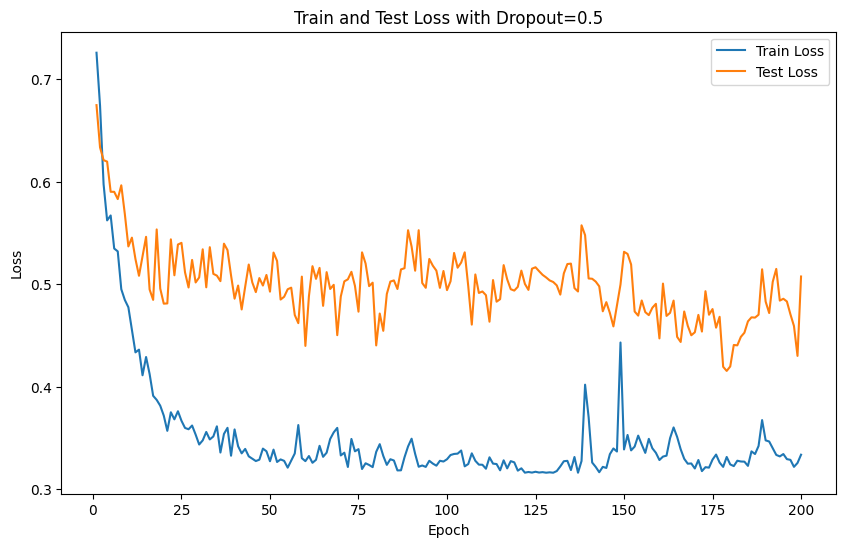

In [31]:
# INSERT CODE HERE
plot_losses(train_losses, test_losses, dropout=0.5)

## Task 9: Compute the minimum train and test loss achieved during training and report them

In [32]:
# INSERT CODE HERE
report_min_losses(train_losses, test_losses)

Minimum train loss 0.3158761039376259 at epoch 137
Minimum test loss 0.41520004471143085 at epoch 179


## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

Epoch 1/200, Loss: 0.7019, Test Loss: 0.7030
Epoch 2/200, Loss: 0.7724, Test Loss: 0.7053
Epoch 3/200, Loss: 0.7545, Test Loss: 0.6901
Epoch 4/200, Loss: 0.7498, Test Loss: 0.6885
Epoch 5/200, Loss: 0.7486, Test Loss: 0.6881
Epoch 6/200, Loss: 0.7486, Test Loss: 0.6924
Epoch 7/200, Loss: 0.6804, Test Loss: 0.6729
Epoch 8/200, Loss: 0.7549, Test Loss: 0.6580
Epoch 9/200, Loss: 0.7026, Test Loss: 0.6565
Epoch 10/200, Loss: 0.7095, Test Loss: 0.6618
Epoch 11/200, Loss: 0.6970, Test Loss: 0.6423
Epoch 12/200, Loss: 0.6661, Test Loss: 0.6334
Epoch 13/200, Loss: 0.6637, Test Loss: 0.6084
Epoch 14/200, Loss: 0.6370, Test Loss: 0.6036
Epoch 15/200, Loss: 0.6171, Test Loss: 0.6010
Epoch 16/200, Loss: 0.6386, Test Loss: 0.6000
Epoch 17/200, Loss: 0.5938, Test Loss: 0.5908
Epoch 18/200, Loss: 0.6101, Test Loss: 0.5677
Epoch 19/200, Loss: 0.6096, Test Loss: 0.5560
Epoch 20/200, Loss: 0.5806, Test Loss: 0.5926
Epoch 21/200, Loss: 0.5557, Test Loss: 0.5753
Epoch 22/200, Loss: 0.5742, Test Loss: 0.59

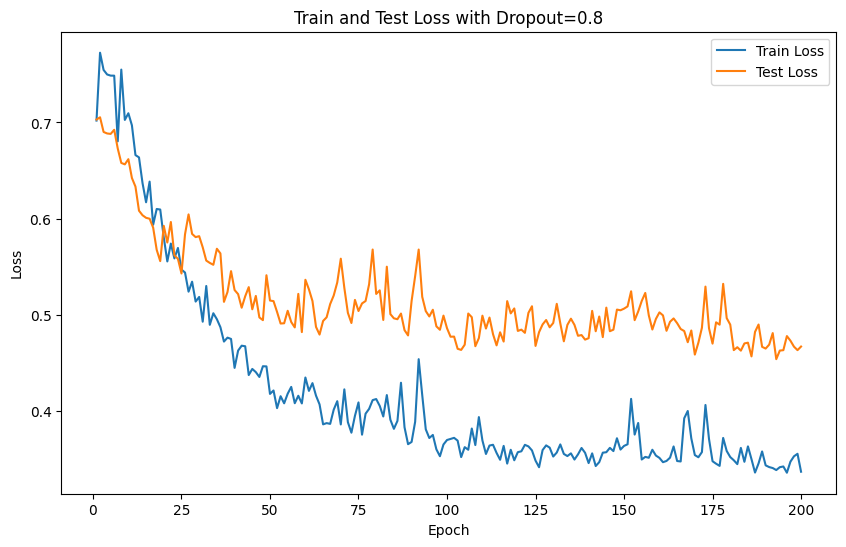

Minimum train loss 0.3363020221392314 at epoch 196
Minimum test loss 0.45421390732129413 at epoch 193


In [33]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

plot_losses(train_losses, test_losses, dropout=0.8)
report_min_losses(train_losses, test_losses)


With the training loss, as we increase dropout, more neurons get randomly turned off during each training iteration. The network is thus less capable of fitting the training data perfectly, which leads to higher training loss and slower convergence on the training loss. In this way, the model is forced to learn robust features that are less reliant on specific subsets of neurons, which aims to increase generalizability. However, with excessive dropout, this can lead to excessive regularization. 

Indeed, at moderate or low levels of dropout the validation loss decreases as the model generalizes better to unseen data. But if the dropout values are too high, the model becomes underfitted, leading to an increase in validation loss as well, because the model is no longer capable of learning enough from the data.